# 🧠 Stock Price Prediction with RSI and Strategy Simulation
This notebook builds a stock market predictor using Random Forest and adds technical indicators like RSI, strategy simulation, and improved visualizations.

In [1]:
# 📌 Step 1: Import Required Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from ta.momentum import RSIIndicator

In [2]:
# 📈 Step 2: Load Historical Stock Data
def load_data(ticker="AAPL", start_date="2000-01-01"):
    stock = yf.Ticker(ticker)
    df = stock.history(period="max")
    df = df.loc[start_date:].copy()
    df.drop(columns=["Dividends", "Stock Splits"], inplace=True, errors='ignore')
    return df

# Load Microsoft stock data
df = load_data("AAPL")
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03 00:00:00-05:00,0.787983,0.845274,0.764034,0.841048,535796800
2000-01-04 00:00:00-05:00,0.813342,0.831186,0.760277,0.770139,512377600
2000-01-05 00:00:00-05:00,0.779530,0.830716,0.773896,0.781409,778321600
2000-01-06 00:00:00-05:00,0.797375,0.803949,0.713787,0.713787,767972800
2000-01-07 00:00:00-05:00,0.725057,0.758868,0.717544,0.747598,460734400


In [3]:
# ⚙️ Step 3: Feature Engineering (RSI, Moving Averages, Trend Signals)
def create_features(data):
    data["Next_Close"] = data["Close"].shift(-1)
    data["Target"] = (data["Next_Close"] > data["Close"]).astype(int)

    # Add 14-day Relative Strength Index
    rsi = RSIIndicator(data["Close"], window=14)
    data["RSI"] = rsi.rsi()

    # Generate rolling average ratios and trend strength
    horizons = [2, 5, 60, 250, 1000]
    for h in horizons:
        data[f"Close_Ratio_{h}"] = data["Close"] / data["Close"].rolling(h).mean()
        data[f"Trend_{h}"] = data["Target"].shift(1).rolling(h).sum()

    return data.dropna()

# Apply feature engineering
df = create_features(df)
df.head()

,Open,High,Low,Close,Volume,Next_Close,Target,RSI,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,0.305802,0.314217,0.305651,0.312263,103695200,0.317823,1,50.637144,1.008983,2.0,1.033316,3.0,0.951842,28.0,1.123531,129.0,0.801992,471.0
2003-12-29 00:00:00-05:00,0.314217,0.317973,0.313465,0.317823,233458400,0.319777,1,54.435125,1.008825,2.0,1.036766,4.0,0.968363,29.0,1.141855,129.0,0.817223,472.0
2003-12-30 00:00:00-05:00,0.318274,0.323083,0.317823,0.319777,204853600,0.321129,1,55.723725,1.003063,2.0,1.028715,4.0,0.974619,29.0,1.147266,129.0,0.823222,472.0
2003-12-31 00:00:00-05:00,0.320828,0.323533,0.318274,0.321129,174451200,0.319777,0,56.638112,1.002110,2.0,1.017716,5.0,0.979429,29.0,1.150513,129.0,0.827540,473.0
2004-01-02 00:00:00-05:00,0.323833,0.326839,0.318274,0.319777,144642400,0.333151,1,55.405861,0.997890,1.0,1.005101,4.0,0.976752,28.0,1.144096,129.0,0.824965,472.0


In [4]:
# 🧠 Step 4: Train Model and Predict Probabilities
def make_predictions(train, test, features, model, threshold=0.67):
    model.fit(train[features], train["Target"])
    probs = model.predict_proba(test[features])[:, 1]
    predictions = (probs >= threshold).astype(int)
    return pd.DataFrame({
        "Predictions": predictions,
        "Probabilities": probs,
        "Actual": test["Target"]
    }, index=test.index)

In [5]:
# 🔁 Step 5: Backtesting Framework
def backtest_model(data, model, features, start=2500, step=250):
    all_results = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i]
        test = data.iloc[i:i+step]
        preds = make_predictions(train, test, features, model)
        all_results.append(preds)
    return pd.concat(all_results)

In [6]:
# 🧪 Step 6: Run the Model and Evaluate
features = [col for col in df.columns if "Close_Ratio" in col or "Trend_" in col] + ["RSI"]
clf = RandomForestClassifier(n_estimators=120, min_samples_split=87, random_state=42)
results = backtest_model(df, clf, features)

# Output metrics
print("Prediction counts:\n", results["Predictions"].value_counts())
print("Precision score:", precision_score(results["Actual"], results["Predictions"]))

Prediction counts:
 Predictions
0    2881
1      44
Name: count, dtype: int64
Precision score: 0.4772727272727273


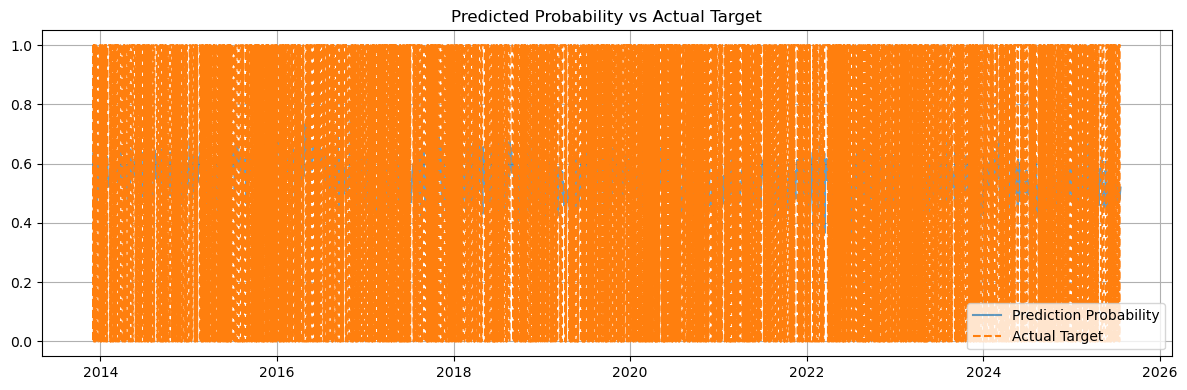

In [7]:
# 📊 Step 7: Visualize Predictions vs. Actual
plt.figure(figsize=(12, 4))
plt.plot(results.index, results["Probabilities"], label="Prediction Probability", alpha=0.7)
plt.plot(results.index, results["Actual"], label="Actual Target", linestyle="--")
plt.title("Predicted Probability vs Actual Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

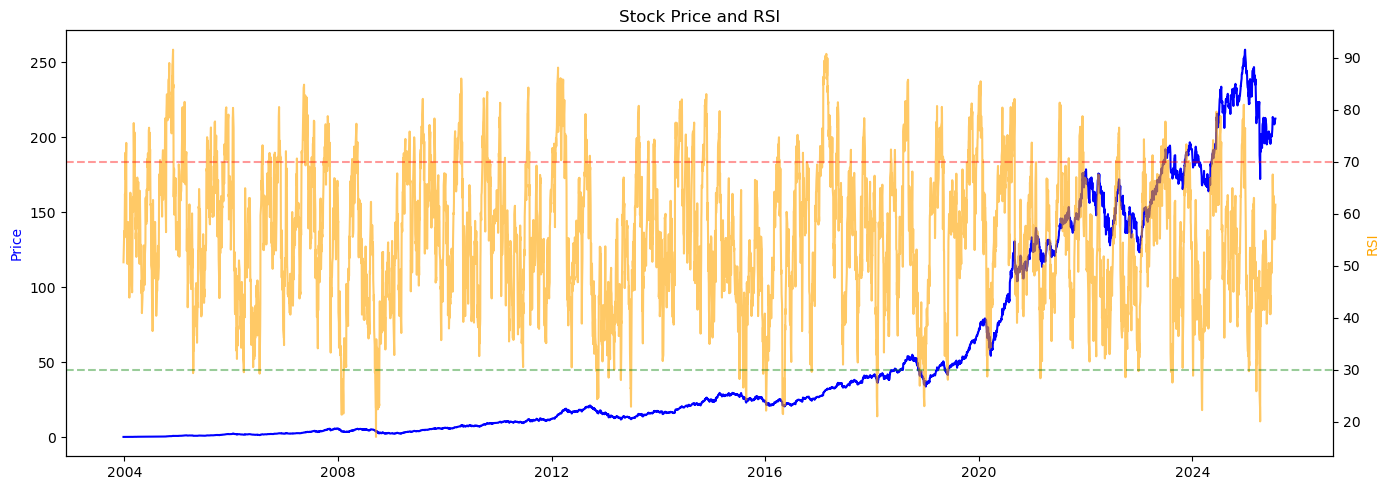

In [8]:
# 📉 Step 8: Visualize RSI and Stock Price
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(df.index, df["Close"], label="Price", color="blue")
ax1.set_ylabel("Price", color="blue")

ax2 = ax1.twinx()
ax2.plot(df.index, df["RSI"], label="RSI", color="orange", alpha=0.6)
ax2.axhline(70, color="red", linestyle="--", alpha=0.4)
ax2.axhline(30, color="green", linestyle="--", alpha=0.4)
ax2.set_ylabel("RSI", color="orange")

plt.title("Stock Price and RSI")
fig.tight_layout()
plt.show()

In [9]:
# 💰 Step 9: Capital Simulation Using Strategy Backtest
def run_strategy(results, initial_capital=10000, investment_fraction=1.0):
    capital = initial_capital
    capital_history = []

    for date, row in results.iterrows():
        if row["Predictions"] == 1:
            prev_close = df.loc[date]["Close"]
            next_day = df.index[df.index.get_loc(date) + 1] if date != df.index[-1] else date
            next_close = df.loc[next_day]["Close"]
            daily_return = (next_close - prev_close) / prev_close
            capital *= (1 + investment_fraction * daily_return)
        capital_history.append(capital)

    results["Capital"] = capital_history
    return results

# Run strategy simulation
results = run_strategy(results)

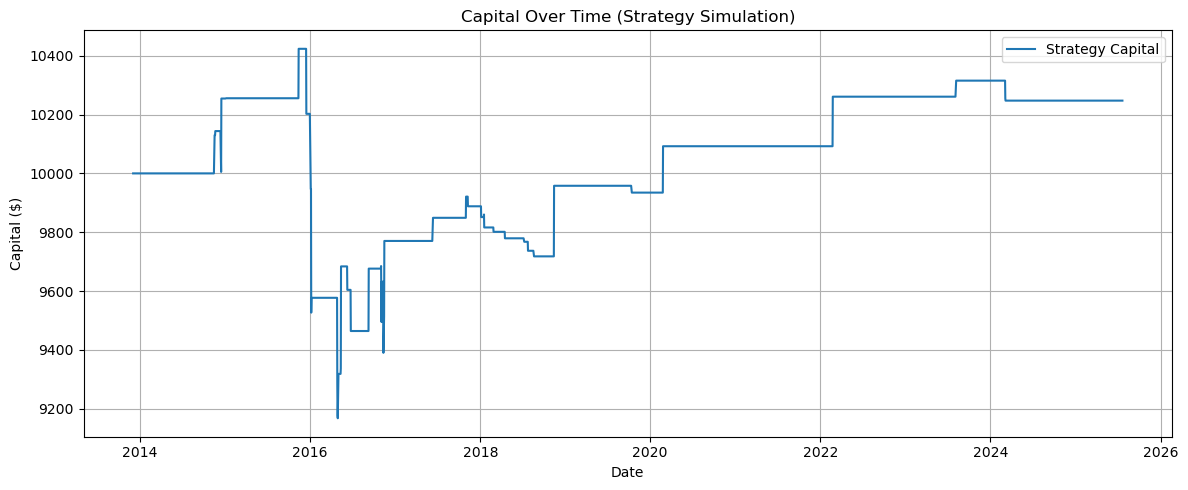

In [10]:
# 📈 Step 10: Visualize Capital Growth
plt.figure(figsize=(12, 5))
plt.plot(results.index, results["Capital"], label="Strategy Capital")
plt.title("Capital Over Time (Strategy Simulation)")
plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# 📊 Final Metric: Total Return
total_return = (results["Capital"].iloc[-1] - 10000) / 10000
print(f"Total return: {total_return:.2%}")

Total return: 2.47%
